# Detecting Breast Tissue Abnormalities in Mammograms through Deep Learning
Project Group 4: Stephanie Landas (sfl7ck), Kristen Rose (krr4de), Michelle Wu (mw3ef)

In [ ]:
# IMPORTS
import os
import math
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tr
from torchvision.models import resnet18, ResNet18_Weights

device = "cuda" if torch.cuda.is_available() else "cpu"

## Load in csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = "/content/drive/MyDrive/DS6050 (Deep Learning) Project/Data"
train_csv_path = os.path.join(root, "csv", "mass_case_description_train_set.csv")
test_csv_path = os.path.join(root, "csv", "mass_case_description_test_set.csv")
images = os.path.join(root, "jpeg")

In [ ]:
train_csv = pd.read_csv(train_csv_path)
test_csv = pd.read_csv(test_csv_path)

In [ ]:
train_csv['pathology'].value_counts()

MALIGNANT                  637
BENIGN                     577
BENIGN_WITHOUT_CALLBACK    104
Name: pathology, dtype: int64

### View one image of each type

In [ ]:
# benign_img_path = train_csv.loc[train_csv['pathology'] == "BENIGN"].iloc[[0]]\
# ['image file path'].values[0]
# benign_img = Image.open(os.path.join(images, benign_img_path.split("/")[-2], \
# os.listdir(os.path.join(images, benign_img_path.split("/")[-2]))[0])).convert("RGB")
# plt.imshow(benign_img)
# plt.title("benign");
# plt.show()

# benign_no_callback_img_path = train_csv.loc[train_csv['pathology'] == "BENIGN_WITHOUT_CALLBACK"].iloc[[0]]\
# ['image file path'].values[0]
# benign_no_callback_img = Image.open(os.path.join(images, benign_no_callback_img_path.split("/")[-2], \
# os.listdir(os.path.join(images, benign_no_callback_img_path.split("/")[-2]))[0])).convert("RGB")
# plt.imshow(benign_no_callback_img)
# plt.title("benign no callback");
# plt.show()

# malignant_img_path = train_csv.loc[train_csv['pathology'] == "MALIGNANT"].iloc[[0]]\
# ['image file path'].values[0]
# malignant_img = Image.open(os.path.join(images, malignant_img_path.split("/")[-2], \
# os.listdir(os.path.join(images, malignant_img_path.split("/")[-2]))[0])).convert("RGB")
# plt.imshow(malignant_img)
# plt.title("malignant");
# plt.show()


## Datasets

In [ ]:
train_data = []
val_data = []

for index, row in train_csv.iterrows():
  path = f"{row['image file path'].split('/')[-2]}"
  if(index < np.round(len(train_csv)*0.85)):
    if(row['pathology'] == "BENIGN_WITHOUT_CALLBACK"):
      train_data.append(os.path.join(images, path, \
    f"BENIGNWITHOUTCALLBACK_{os.listdir(os.path.join(images, row['image file path'].split('/')[-2]))[0]}"))
    else:
      train_data.append(os.path.join(images, path, \
    f"{row['pathology']}_{os.listdir(os.path.join(images, row['image file path'].split('/')[-2]))[0]}"))
  else:
    if(row['pathology'] == "BENIGN_WITHOUT_CALLBACK"):
      val_data.append(os.path.join(images, path, \
    f"BENIGNWITHOUTCALLBACK_{os.listdir(os.path.join(images, row['image file path'].split('/')[-2]))[0]}"))
    else:
      val_data.append(os.path.join(images, path, \
    f"{row['pathology']}_{os.listdir(os.path.join(images, row['image file path'].split('/')[-2]))[0]}"))

print(f"train data: {len(train_data)}, val data: {len(val_data)}")

train data: 1120, val data: 198


In [ ]:
class ClassifierDataset(Dataset):
  def __init__(self, image_paths, class_dict, transforms):
    self.paths = image_paths
    self.class_dict = class_dict
    self.transforms = transforms

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    path = self.paths[idx]
    actual_path = f"{'/'.join(path.split('/')[:-1])}/{os.path.basename(path)[:-4].split('_')[-1]}.jpg"
    pil_img = Image.open(actual_path).convert("RGB")
    tensor = self.transforms(pil_img)
    label = os.path.basename(path)[:-4].split("_")[0]
    if(label == "BENIGN"):
      label = "benign"
    elif(label == "BENIGNWITHOUTCALLBACK"):
      label = "normal"
    else:
      label = "malignant"
    label = self.class_dict[label]
    return tensor, label


## Dataloader

In [ ]:
batch_size = 16
class_dict = {"benign": 0, "normal": 1, "malignant": 2}
transforms = tr.Compose([tr.ToTensor(), tr.Resize((1024, 1024), antialias = True), tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataloader = DataLoader(dataset=ClassifierDataset(image_paths=train_data, class_dict=class_dict, transforms=transforms),
                              batch_size=batch_size,
                              num_workers=0,
                              shuffle=True)
val_dataloader = DataLoader(dataset=ClassifierDataset(image_paths=val_data, class_dict=class_dict, transforms=transforms),
                              batch_size=batch_size,
                              num_workers=0,
                              shuffle=True)
dataloader_dict = {"train": train_dataloader, "val": val_dataloader}



## Hyperparameters

In [ ]:
epochs = 100
learning_rate = 0.001
weight_decay = 0.00001
momentum = 0.9


## Load in pretrained model

In [ ]:
model = resnet18(weights=ResNet18_Weights)
model_name = "multi_classify_breast_cancer_resnet18"
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.3MB/s]


In [ ]:
model.to(device)
metrics = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_loss = np.inf
for epoch in range(epochs):
  print(f"Epoch {epoch}")
  for phase in ["train", "val"]:
    if(phase == "train"):
      model.train()
    else:
      model.eval()
    running_loss = 0.0
    running_correct = 0.0
    loader = dataloader_dict[phase]
    for inputs, labels in tqdm(loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      with torch.set_grad_enabled(phase == "train"):
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        preds = torch.argmax(outputs, dim=1)

        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(preds == labels.data)

      if(phase == "train"):
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss/len(dataloader_dict[phase].dataset)
    epoch_acc = running_correct/len(dataloader_dict[phase].dataset)
    print(f"{phase}; Loss: {epoch_loss}, Acc: {epoch_acc}")

    if(phase == "train"):
      metrics["epoch"].append(epoch)
      metrics["train_loss"].append(epoch_loss)
      metrics["train_acc"].append(epoch_acc)
    else:
      metrics["val_loss"].append(epoch_loss)
      metrics["val_acc"].append(epoch_acc)

    if(epoch_loss < best_loss and phase == "val"):
      best_loss = epoch_loss
      torch.save(model, f"/content/drive/MyDrive/DS6050 (Deep Learning) Project/model - multiclass_resnet18/{model_name}_best_model.pth")

    torch.save(model, f"/content/drive/MyDrive/DS6050 (Deep Learning) Project/model - multiclass_resnet18/history/{model_name}_epoch{epoch}.pth")

    with open(f"/content/drive/MyDrive/DS6050 (Deep Learning) Project/model - multiclass_resnet18/metrics.pkl", 'wb') as handle:
      pickle.dump(metrics, handle)



Epoch 0


100%|██████████| 70/70 [17:15<00:00, 14.79s/it]


train; Loss: 1.7287502293075834, Acc: 0.5089285969734192


100%|██████████| 13/13 [03:07<00:00, 14.43s/it]


val; Loss: 0.896669829132581, Acc: 0.560606062412262
Epoch 1


100%|██████████| 70/70 [11:51<00:00, 10.16s/it]


train; Loss: 0.760237716776984, Acc: 0.610714316368103


100%|██████████| 13/13 [02:02<00:00,  9.40s/it]


val; Loss: 1.0062823963887764, Acc: 0.5353535413742065
Epoch 2


100%|██████████| 70/70 [11:49<00:00, 10.13s/it]


train; Loss: 0.6723232401268823, Acc: 0.6767857074737549


100%|██████████| 13/13 [02:05<00:00,  9.65s/it]


val; Loss: 1.1013465192582872, Acc: 0.4595959484577179
Epoch 3


100%|██████████| 70/70 [12:05<00:00, 10.36s/it]


train; Loss: 0.6618635109492711, Acc: 0.6875


100%|██████████| 13/13 [02:01<00:00,  9.34s/it]


val; Loss: 0.9761806088264542, Acc: 0.5707070827484131
Epoch 4


100%|██████████| 70/70 [12:02<00:00, 10.32s/it]


train; Loss: 0.5993830510548183, Acc: 0.7392857074737549


100%|██████████| 13/13 [02:04<00:00,  9.59s/it]


val; Loss: 1.1070636709531148, Acc: 0.5050504803657532
Epoch 5


100%|██████████| 70/70 [12:04<00:00, 10.34s/it]


train; Loss: 0.5687668368220329, Acc: 0.7571428418159485


100%|██████████| 13/13 [02:06<00:00,  9.71s/it]


val; Loss: 1.005055798424615, Acc: 0.6464646458625793
Epoch 6


100%|██████████| 70/70 [11:57<00:00, 10.26s/it]


train; Loss: 0.5214472715343748, Acc: 0.7732142806053162


100%|██████████| 13/13 [02:04<00:00,  9.55s/it]


val; Loss: 0.8994957678245775, Acc: 0.5909090638160706
Epoch 7


100%|██████████| 70/70 [12:01<00:00, 10.31s/it]


train; Loss: 0.4536238947084972, Acc: 0.8053571581840515


100%|██████████| 13/13 [02:06<00:00,  9.73s/it]


val; Loss: 2.2216193784366953, Acc: 0.4292929172515869
Epoch 8


100%|██████████| 70/70 [12:11<00:00, 10.45s/it]


train; Loss: 0.3973517200776509, Acc: 0.8446428775787354


100%|██████████| 13/13 [02:07<00:00,  9.79s/it]


val; Loss: 1.3174803485774031, Acc: 0.5202020406723022
Epoch 9


100%|██████████| 70/70 [11:51<00:00, 10.16s/it]


train; Loss: 0.41122321699346814, Acc: 0.8303571343421936


100%|██████████| 13/13 [01:55<00:00,  8.87s/it]


val; Loss: 1.2178893342162624, Acc: 0.5
Epoch 10


 23%|██▎       | 16/70 [02:44<09:25, 10.47s/it]

## Inference/ Evaluation results

In [ ]:
batch_size = 16
class_dict = {"benign": 0, "normal": 1, "malignant": 2}
transforms = tr.Compose([tr.ToTensor(), tr.Resize((1024, 1024), antialias = True), tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [ ]:
test_data = []

for index, row in test_csv.iterrows():
  path = f"{row['image file path'].split('/')[-2]}"
  if(row['pathology'] == "BENIGN_WITHOUT_CALLBACK"):
    test_data.append(os.path.join(images, path, \
  f"BENIGNWITHOUTCALLBACK_{os.listdir(os.path.join(images, row['image file path'].split('/')[-2]))[0]}"))
  else:
    test_data.append(os.path.join(images, path, \
  f"{row['pathology']}_{os.listdir(os.path.join(images, row['image file path'].split('/')[-2]))[0]}"))


print(f"test data: {len(test_data)}")

test_dataloader = DataLoader(dataset=ClassifierDataset(image_paths=test_data, class_dict=class_dict, transforms=transforms),
                             batch_size=1,
                             num_workers=0,
                             shuffle=True)

test data: 378


In [ ]:
model_path  = "/content/drive/MyDrive/DS6050 (Deep Learning) Project/model - multiclass_resnet18/multi_classify_breast_cancer_resnet18_best_model.pth"
model = torch.load(model_path, map_location=device)
model = model.eval()

In [ ]:
preds = []
actuals = []
for inputs, labels in tqdm(test_dataloader):
  inputs = inputs.to(device)
  labels = labels.to(device)
  output = model(inputs)
  pred = torch.argmax(output, dim=1).cpu().detach().numpy()
  preds.append(pred)
  actuals.append(labels.cpu().detach().numpy())


100%|██████████| 378/378 [03:56<00:00,  1.60it/s]


In [ ]:
recall = metrics.recall_score(actuals, preds, average="micro")
precision = metrics.precision_score(actuals, preds, average="micro")
print(f"recall: {recall}")
print(f"precision: {precision}")

recall: 0.544973544973545
precision: 0.544973544973545


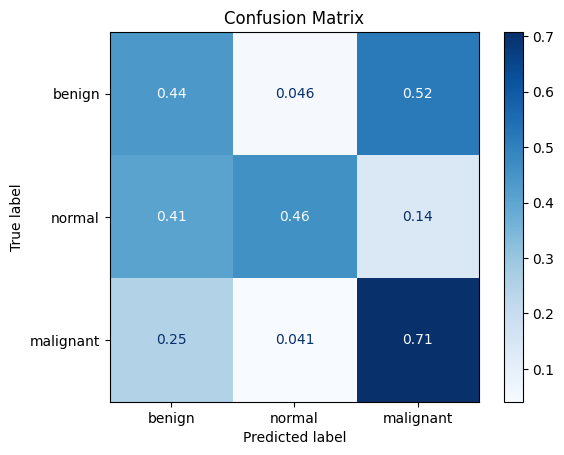

In [ ]:
confusion_matrix = metrics.confusion_matrix(actuals, preds, normalize="true")
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=list(class_dict.keys()))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()